In [1]:
import spike.spike_analysis.spike_collection as sc
import spike.spike_analysis.spike_recording as sr
import spike.spike_analysis.firing_rate_calculations as fr
import spike.spike_analysis.normalization as norm
import spike.spike_analysis.single_cell as single_cell
import spike.spike_analysis.spike_collection as collection
import spike.spike_analysis.zscoring as zscoring
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import behavior.boris_extraction as boris
import matplotlib.pyplot as plt
import pickle
import re

In [2]:
pd.set_option('display.max_colwidth', 0)  # 0 means unlimited in newer pandas versions

# Show all rows
pd.set_option("display.max_rows", None)

# Show all columns
pd.set_option("display.max_columns", None)

# Don’t truncate column contents
pd.set_option("display.max_colwidth", None)

# Expand the display to the full width of the screen
pd.set_option("display.width", 0)


In [3]:
spike_collection_json_path = r'C:\Users\thoma\Code\ResearchCode\diff_fam_social_memory_ephys\spike_collection.json\spike_collection.json'

In [4]:
sp = sc.SpikeCollection.load_collection(spike_collection_json_path)

In [5]:
def run_zscore_event_specific_baseline(recording, event_name, pre_window=10, equalize=10, timebin=0.25, SD=1.65, verbose=False):
    """
    Z-score event firing rates using an event-specific baseline per unit.
    This function calculates the z-score of firing rates for a specific event type
    based on a baseline computed from the pre-event windows of that event type only.
    Uses a PSTH-like approach: averages across trials per timebin, then across timebins.
    
    Parameters:
    - recording: SpikeRecording object containing spike data and events.
    - event_name: Name of the event type to analyze.
    - pre_window: Duration in seconds before the event to use for baseline calculation.
    - equalize: Duration in seconds of the event window to analyze.
    - timebin: Duration in seconds of each timebin for firing rate calculations (default 0.25s = 250ms).
    - SD: Number of standard deviations to use for significance thresholding.
    - verbose: If True, prints additional information during processing.
    
    Returns:
    - A pandas DataFrame containing the z-scores and significance of firing rates for each unit
      for the specified event type, along with baseline and event means and standard deviations.
    """
    # Step 1: Initialize units and baseline/event firing rates
    units = getattr(recording, "good_units", None)  # Get good units if available
    if units is None:  # If not, use labels_dict
        units = [unit_id for unit_id, label in recording.labels_dict.items() if label == "good"]
        if verbose:
            print("Using labels_dict to determine good units.")
            print(f"Good units found: {units}\nFrom labels_dict: {recording.labels_dict}\n")

    # Initialize dictionaries for baseline and event firing rate matrices (list of arrays per unit)
    baseline_fr_matrices = {unit_id: [] for unit_id in units}
    event_fr_matrices = {unit_id: [] for unit_id in units}

    # Convert timebin and sampling rate to milliseconds for consistency
    timebin_ms = timebin * 1000
    sampling_rate = recording.sampling_rate

    # Step 2: Compute firing rates for baseline and event windows per trial
    event_windows = recording.event_dict[event_name]
    for unit_id in units:
        spikes = recording.unit_timestamps[unit_id]  # Array of spike timestamps in samples
        spikes_ms = spikes * (1000 / sampling_rate)  # Convert to milliseconds

        for window in event_windows:
            start_event = window[0]  # Event start in ms
            end_event = min(window[1], start_event + equalize * 1000)  # Event end, trimmed to equalize duration
            start_baseline = start_event - int(pre_window * 1000)  # Baseline start in ms
            end_baseline = start_event  # Baseline ends at event onset

            # Calculate baseline firing rates (in timebins)
            baseline_bins = np.arange(start_baseline, end_baseline + timebin_ms, timebin_ms)  # Include end for full coverage
            baseline_spike_counts = np.histogram(spikes_ms, bins=baseline_bins)[0]
            baseline_firing_rate = baseline_spike_counts * (1000 / timebin_ms)  # Convert to Hz
            baseline_fr_matrices[unit_id].append(baseline_firing_rate)

            # Calculate event firing rates (in timebins)
            event_bins = np.arange(start_event, end_event + timebin_ms, timebin_ms)  # Include end for full coverage
            event_spike_counts = np.histogram(spikes_ms, bins=event_bins)[0]
            event_firing_rate = event_spike_counts * (1000 / timebin_ms)  # Convert to Hz
            event_fr_matrices[unit_id].append(event_firing_rate)

            #if verbose:
                #print(f"Unit {unit_id}, Event {event_name}, Window {window}")
                #print(f"Baseline firing rates: {baseline_firing_rate}")
                #print(f"Event firing rates: {event_firing_rate}\n")

    # Step 3: Compute mean and SD for baseline and event per unit using PSTH-like averaging
    rows = []
    for unit_id in units:
        # Convert lists to numpy arrays (shape: num_trials x num_bins)
        baseline_fr_matrix = np.array(baseline_fr_matrices[unit_id])

        # printing out whole matrix if verbose
        if verbose:
            print(f"Event name: {event_name}")
            print(f"Baseline FR matrix shape for unit {unit_id}: {baseline_fr_matrix.shape}")
            print(f"Baseline FR matrix for unit {unit_id}:\n{baseline_fr_matrix}\n")

        event_fr_matrix = np.array(event_fr_matrices[unit_id])

        if baseline_fr_matrix.size == 0 or event_fr_matrix.size == 0:
            b_mean = np.nan
            b_sd = np.nan
            ev_mean = np.nan
            zscore = np.nan
        else:
            # Check for consistent bin counts across trials
            if len(set(len(row) for row in baseline_fr_matrices[unit_id])) > 1:
                raise ValueError(f"Inconsistent baseline bin counts for unit {unit_id}")
            if len(set(len(row) for row in event_fr_matrices[unit_id])) > 1:
                raise ValueError(f"Inconsistent event bin counts for unit {unit_id}")

            # Baseline: mean per bin across trials, then overall mean across bins
            b_mean_per_bin = np.mean(baseline_fr_matrix, axis=0)
            b_mean = np.mean(b_mean_per_bin) if len(b_mean_per_bin) > 0 else np.nan

            # Baseline SD: SD per bin across trials, then mean SD across bins
            b_sd_per_bin = np.std(baseline_fr_matrix, axis=0, ddof=1)  # Use ddof=1 for sample std
            b_sd = np.mean(b_sd_per_bin) if len(b_sd_per_bin) > 0 else np.nan
            # b_sd = np.std(b_mean_per_bin, ddof=1) if len(b_mean_per_bin) > 1 else np.nan

            # Event: mean per bin across trials, then overall mean across bins
            ev_mean_per_bin = np.mean(event_fr_matrix, axis=0)
            ev_mean = np.mean(ev_mean_per_bin) if len(ev_mean_per_bin) > 0 else np.nan

            # Calculate z-score
            zscore = np.nan if np.isnan(b_sd) or b_sd == 0 else (ev_mean - b_mean) / b_sd

        # Append results to rows
        rows.append({
            "Recording": recording.name,
            "Event name": event_name,
            "Unit number": unit_id,
            "Pre-event M": b_mean,
            "Pre-event SD": b_sd,
            "Event M": ev_mean,
            "Event Z-Score": zscore,
        })

    # Create DataFrame
    df = pd.DataFrame(rows)

    # Step 4: Apply significance threshold
    conditions = [
        (df['Event Z-Score'] > SD),
        (df['Event Z-Score'] < -SD)
    ]
    values = ['increase', 'decrease']
    df['sig'] = np.select(conditions, values, default='not sig')

    return df

def get_recording_time_periods(recording, n_periods=3):
    """
    Split recording into time periods based on the total duration.
    
    Parameters:
    - recording: SpikeRecording object
    - n_periods: Number of time periods to split into (default: 3)
    
    Returns:
    - List of tuples (start_time_ms, end_time_ms) for each period
    """
    # Get the total duration of the recording
    # Assuming the recording has a duration attribute or we can calculate from timestamps
    if hasattr(recording, 'duration_ms'):
        total_duration_ms = recording.duration_ms
    elif hasattr(recording, 'duration'):
        total_duration_ms = recording.duration * 1000  # convert to ms
    else:
        # Calculate from the maximum timestamp across all units
        max_timestamp = 0
        for unit_id in recording.unit_timestamps:
            unit_max = np.max(recording.unit_timestamps[unit_id])
            max_timestamp = max(max_timestamp, unit_max)
        total_duration_ms = max_timestamp * (1000 / recording.sampling_rate)
    
    # Split into equal periods
    period_duration = total_duration_ms / n_periods
    periods = []
    
    for i in range(n_periods):
        start_time = i * period_duration
        end_time = (i + 1) * period_duration
        periods.append((start_time, end_time))
    
    return periods

def filter_events_by_time_period(event_windows, start_time_ms, end_time_ms):
    """
    Filter event windows to only include those that fall within the specified time period.
    
    Parameters:
    - event_windows: List of [start, end] event windows
    - start_time_ms: Start of time period in milliseconds
    - end_time_ms: End of time period in milliseconds
    
    Returns:
    - Filtered list of event windows
    """
    filtered_windows = []
    for window in event_windows:
        event_start = window[0]
        # Check if the event start falls within this time period
        if start_time_ms <= event_start < end_time_ms:
            filtered_windows.append(window)
    
    return filtered_windows

def run_zscore_event_specific_baseline_by_period(recording, event_name, time_period, period_num, pre_window=10, equalize=10, timebin=0.25, SD=1.65, verbose=False):
    """
    Z-score event firing rates using an event-specific baseline per unit,
    but only analyze events from a specific time period.
    Uses a PSTH-like approach: averages across trials per timebin, then across timebins.
    
    Parameters:
    - recording: SpikeRecording object containing spike data and events.
    - event_name: Name of the event type to analyze.
    - time_period: Tuple of (start_time_ms, end_time_ms) for this period
    - period_num: Period number (for labeling)
    - pre_window: Duration in seconds before the event to use for baseline calculation.
    - equalize: Duration in seconds of the event window to analyze.
    - timebin: Duration in seconds of each timebin for firing rate calculations (default 0.25s = 250ms).
    - SD: Number of standard deviations to use for significance thresholding.
    - verbose: If True, prints additional information during processing.
    
    Returns:
    - A pandas DataFrame containing the z-scores and significance of firing rates for each unit
    for the specified event type in the specified time period.
    """
    start_time_ms, end_time_ms = time_period
    
    # Step 1: Filter events for the target event type to only this time period
    if event_name not in recording.event_dict:
        return pd.DataFrame()  # Return empty if event doesn't exist
    
    all_event_windows = recording.event_dict[event_name]
    period_event_windows = filter_events_by_time_period(all_event_windows, start_time_ms, end_time_ms)
    
    if not period_event_windows:
        return pd.DataFrame()  # Return empty if no events in this period
    
    if verbose:
        print(f"Period {period_num}: {len(period_event_windows)} events out of {len(all_event_windows)} total events")

    # Step 2: Initialize units and baseline/event firing rates
    units = getattr(recording, "good_units", None)  # Get good units if available
    if units is None:  # If not, use labels_dict
        units = [unit_id for unit_id, label in recording.labels_dict.items() if label == "good"]
        if verbose:
            print("Using labels_dict to determine good units.")
            print(f"Good units found: {units}\nFrom labels_dict: {recording.labels_dict}\n")

    # Initialize dictionaries for baseline and event firing rate matrices (list of arrays per unit)
    baseline_fr_matrices = {unit_id: [] for unit_id in units}
    event_fr_matrices = {unit_id: [] for unit_id in units}

    # Convert timebin and sampling rate to milliseconds for consistency
    timebin_ms = timebin * 1000
    sampling_rate = recording.sampling_rate

    # Step 3: Compute firing rates for baseline and event windows per trial (only for events in this period)
    for unit_id in units:
        spikes = recording.unit_timestamps[unit_id]  # Array of spike timestamps in samples
        spikes_ms = spikes * (1000 / sampling_rate)  # Convert to milliseconds

        for window in period_event_windows:
            start_event = window[0]  # Event start in ms
            end_event = min(window[1], start_event + equalize * 1000)  # Event end, trimmed to equalize duration
            start_baseline = start_event - int(pre_window * 1000)  # Baseline start in ms
            end_baseline = start_event  # Baseline ends at event onset

            # Calculate baseline firing rates (in timebins)
            baseline_bins = np.arange(start_baseline, end_baseline + timebin_ms, timebin_ms)  # Include end for full coverage
            baseline_spike_counts = np.histogram(spikes_ms, bins=baseline_bins)[0]
            baseline_firing_rate = baseline_spike_counts * (1000 / timebin_ms)  # Convert to Hz
            baseline_fr_matrices[unit_id].append(baseline_firing_rate)

            # Calculate event firing rates (in timebins)
            event_bins = np.arange(start_event, end_event + timebin_ms, timebin_ms)  # Include end for full coverage
            event_spike_counts = np.histogram(spikes_ms, bins=event_bins)[0]
            event_firing_rate = event_spike_counts * (1000 / timebin_ms)  # Convert to Hz
            event_fr_matrices[unit_id].append(event_firing_rate)

            if verbose:
                print(f"Unit {unit_id}, Event {event_name}, Window {window}")
                print(f"Baseline firing rates: {baseline_firing_rate}")
                print(f"Event firing rates: {event_firing_rate}\n")

    # Step 4: Compute mean and SD for baseline and event per unit using PSTH-like averaging
    rows = []
    for unit_id in units:
        # Convert lists to numpy arrays (shape: num_trials x num_bins)
        baseline_fr_matrix = np.array(baseline_fr_matrices[unit_id])

        # printing out whole matrix if verbose
        if verbose:
            print(f"Event name: {event_name}")
            print(f"Baseline FR matrix shape for unit {unit_id}: {baseline_fr_matrix.shape}")
            print(f"Baseline FR matrix for unit {unit_id}:\n{baseline_fr_matrix}\n")

        event_fr_matrix = np.array(event_fr_matrices[unit_id])

        if baseline_fr_matrix.size == 0 or event_fr_matrix.size == 0:
            b_mean = np.nan
            b_sd = np.nan
            ev_mean = np.nan
            zscore = np.nan
        else:
            # Check for consistent bin counts across trials
            if len(set(len(row) for row in baseline_fr_matrices[unit_id])) > 1:
                raise ValueError(f"Inconsistent baseline bin counts for unit {unit_id}")
            if len(set(len(row) for row in event_fr_matrices[unit_id])) > 1:
                raise ValueError(f"Inconsistent event bin counts for unit {unit_id}")

            # Baseline: mean per bin across trials, then overall mean across bins
            b_mean_per_bin = np.mean(baseline_fr_matrix, axis=0)
            b_mean = np.mean(b_mean_per_bin) if len(b_mean_per_bin) > 0 else np.nan

            # Baseline SD: SD per bin across trials, then mean SD across bins
            b_sd_per_bin = np.std(baseline_fr_matrix, axis=0, ddof=1)  # Use ddof=1 for sample std
            b_sd = np.mean(b_sd_per_bin) if len(b_sd_per_bin) > 0 else np.nan
            # b_sd = np.std(b_mean_per_bin, ddof=1) if len(b_mean_per_bin) > 1 else np.nan

            # Event: mean per bin across trials, then overall mean across bins
            ev_mean_per_bin = np.mean(event_fr_matrix, axis=0)
            ev_mean = np.mean(ev_mean_per_bin) if len(ev_mean_per_bin) > 0 else np.nan

            # Calculate z-score
            zscore = np.nan if np.isnan(b_sd) or b_sd == 0 else (ev_mean - b_mean) / b_sd

        # Append results to rows
        rows.append({
            "Recording": recording.name,
            "Event name": event_name,
            "Time Period": period_num,
            "Period Start (ms)": start_time_ms,
            "Period End (ms)": end_time_ms,
            "Unit number": unit_id,
            "Pre-event M": b_mean,
            "Pre-event SD": b_sd,
            "Event M": ev_mean,
            "Event Z-Score": zscore,
            "Events in Period": len(period_event_windows)
        })

    # Create DataFrame
    df = pd.DataFrame(rows)
    
    if df.empty:
        return df

    # Step 5: Apply significance threshold
    conditions = [
        (df['Event Z-Score'] > SD),
        (df['Event Z-Score'] < -SD)
    ]
    values = ['increase', 'decrease']
    df['sig'] = np.select(conditions, values, default='not sig')

    return df

def run_all_recordings_all_events_by_periods(sp, n_periods=3, pre_window=10, equalize=10, timebin=0.25, SD=1.65, verbose=False):
    """
    Run z-score analysis for all recordings and events, split by time periods.
    Uses event-specific baseline calculation with PSTH-like approach.
    
    Parameters:
    - sp: SpikeCollection object
    - n_periods: Number of time periods to split each recording into
    - pre_window: Duration in seconds before the event to use for baseline calculation
    - equalize: Duration in seconds of the event window to analyze
    - timebin: Duration in seconds of each timebin for firing rate calculations (default 0.25s = 250ms)
    - SD: Number of standard deviations to use for significance thresholding
    - verbose: If True, prints additional information during processing
    
    Returns:
    - big_df: DataFrame with all results
    - skipped_df: DataFrame with skipped recordings/events and reasons
    """
    all_event_names = sorted({ev for rec in sp.recordings for ev in rec.event_dict.keys()})
    dfs = []
    skipped = []

    for rec in sp.recordings:
        if verbose:
            print(f"\nProcessing recording: {rec.name}")
        
        # Get time periods for this recording
        time_periods = get_recording_time_periods(rec, n_periods)
        
        if verbose:
            print(f"Time periods: {time_periods}")
        
        for period_num, time_period in enumerate(time_periods, 1):
            for ev in all_event_names:
                if ev not in rec.event_dict or len(rec.event_dict[ev]) == 0:
                    skipped.append((rec.name, ev, period_num, "no windows"))
                    continue
                
                try:
                    df_ev = run_zscore_event_specific_baseline_by_period(
                        rec, ev, time_period, period_num, 
                        pre_window=pre_window, equalize=equalize, timebin=timebin, 
                        SD=SD, verbose=verbose
                    )
                    
                    if not df_ev.empty:
                        dfs.append(df_ev)
                    else:
                        skipped.append((rec.name, ev, period_num, "empty result"))
                        
                except Exception as e:
                    skipped.append((rec.name, ev, period_num, f"error: {e}"))
                    if verbose:
                        print(f"[WARN] {rec.name} / {ev} / Period {period_num} -> {e}")

    big_df = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()
    skipped_df = pd.DataFrame(skipped, columns=["Recording", "Event name", "Time Period", "reason"])
    
    return big_df, skipped_df


In [6]:
# Run the analysis with time periods using event-specific baseline
results_df, skipped_df = run_all_recordings_all_events_by_periods(
    sp, n_periods=3, pre_window=10, equalize=10, timebin=0.25, SD=1.65, verbose=False
)

# Check the results
# print(f"Total results: {len(results_df)}")
# print(f"Skipped: {len(skipped_df)}")
# print("\nFirst few results:")
# print(results_df.head())

c:\Users\thoma\miniconda3\envs\ephys_env\lib\site-packages\numpy\_core\_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\thoma\miniconda3\envs\ephys_env\lib\site-packages\numpy\_core\_methods.py:212: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Users\thoma\miniconda3\envs\ephys_env\lib\site-packages\numpy\_core\_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\thoma\miniconda3\envs\ephys_env\lib\site-packages\numpy\_core\_methods.py:212: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Users\thoma\miniconda3\envs\ephys_env\lib\site-packages\numpy\_core\_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\thoma\miniconda3\envs\ephys_env\lib\site-packages\numpy\_core\_method

In [7]:
# sig only datafrme
sig_df = results_df[results_df['sig'] != 'not sig']

## High comp win

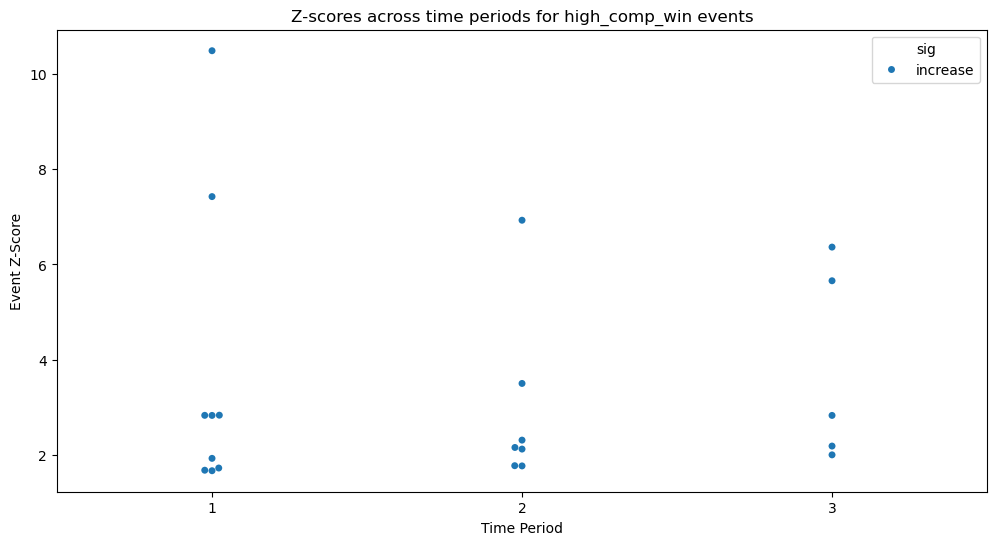

In [8]:
# Example of how you might plot later:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for a specific event type
event_data = sig_df[sig_df['Event name'] == 'high_comp_win']

# Create swarm plot by time period
plt.figure(figsize=(12, 6))
sns.swarmplot(data=event_data, x='Time Period', y='Event Z-Score', hue='sig')
plt.title('Z-scores across time periods for high_comp_win events')
plt.show()

### Low Comp Win

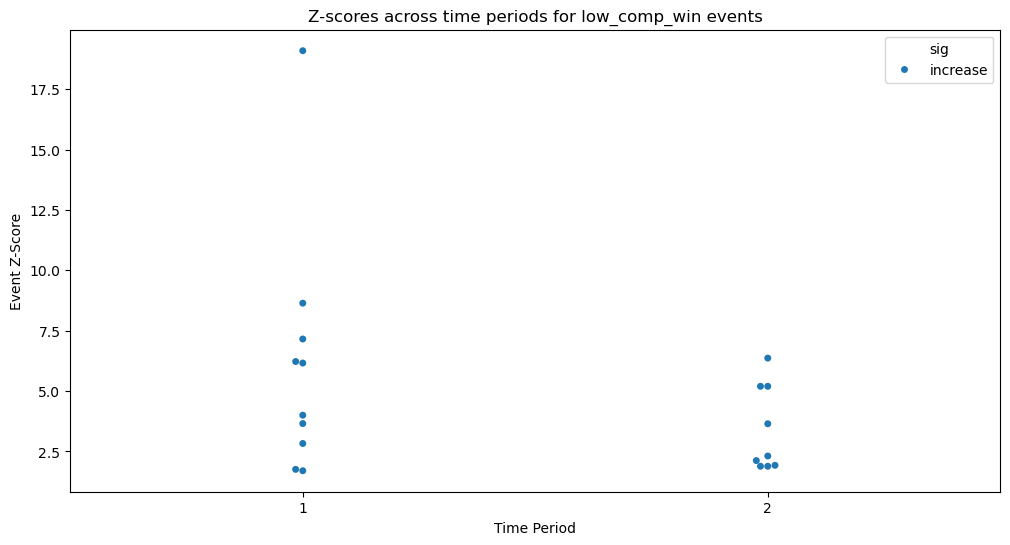

In [9]:
# Example of how you might plot later:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for a specific event type
event_data = sig_df[sig_df['Event name'] == 'low_comp_win']

# Create swarm plot by time period
plt.figure(figsize=(12, 6))
sns.swarmplot(data=event_data, x='Time Period', y='Event Z-Score', hue='sig')
plt.title('Z-scores across time periods for low_comp_win events')
plt.show()

### High comp Lose

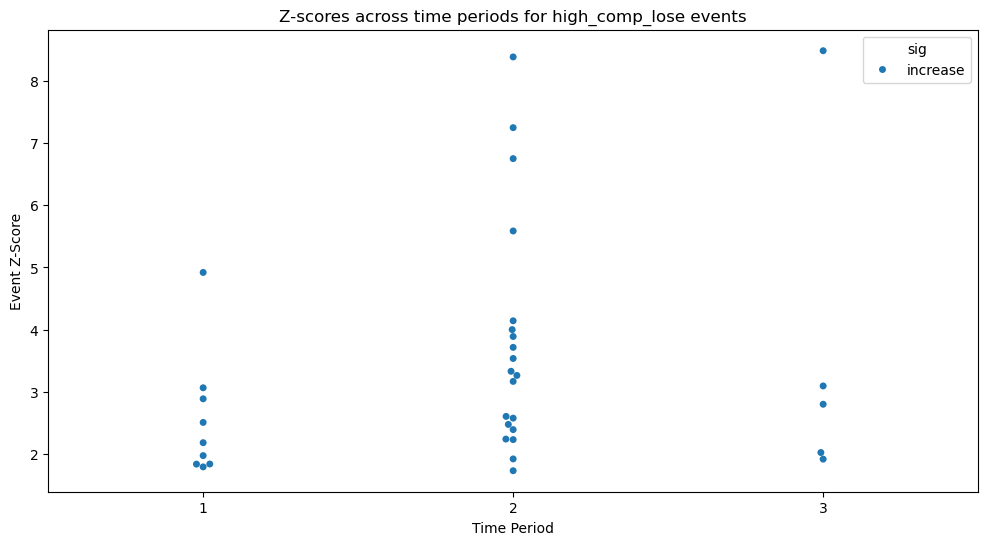

In [10]:
# Example of how you might plot later:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for a specific event type
event_data = sig_df[sig_df['Event name'] == 'high_comp_lose']

# Create swarm plot by time period
plt.figure(figsize=(12, 6))
sns.swarmplot(data=event_data, x='Time Period', y='Event Z-Score', hue='sig')
plt.title('Z-scores across time periods for high_comp_lose events')
plt.show()

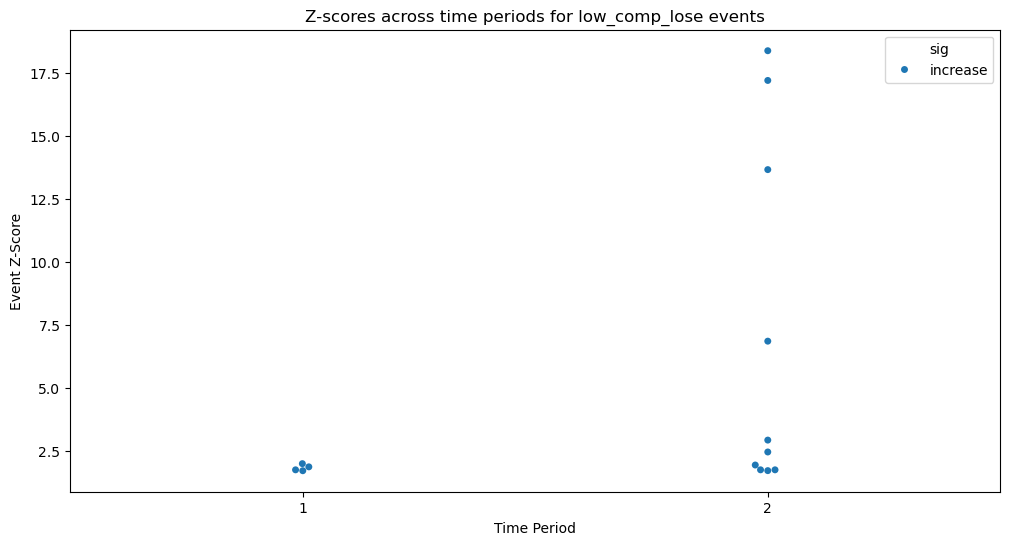

In [11]:
# Example of how you might plot later:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for a specific event type
event_data = sig_df[sig_df['Event name'] == 'low_comp_lose']

# Create swarm plot by time period
plt.figure(figsize=(12, 6))
sns.swarmplot(data=event_data, x='Time Period', y='Event Z-Score', hue='sig')
plt.title('Z-scores across time periods for low_comp_lose events')
plt.show()

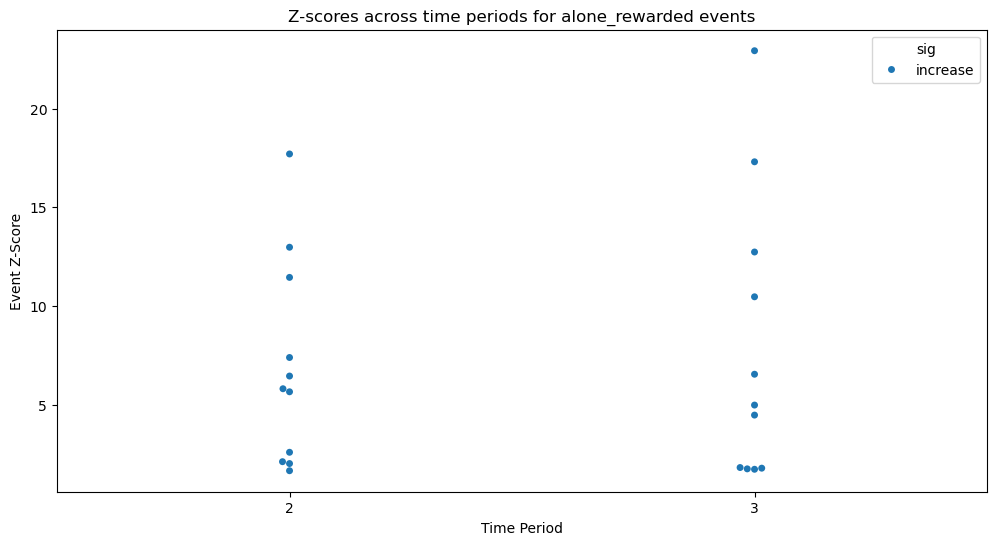

In [12]:
# Example of how you might plot later:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for a specific event type
event_data = sig_df[sig_df['Event name'] == 'alone_rewarded']

# Create swarm plot by time period
plt.figure(figsize=(12, 6))
sns.swarmplot(data=event_data, x='Time Period', y='Event Z-Score', hue='sig')
plt.title('Z-scores across time periods for alone_rewarded events')
plt.show()